<a href="https://colab.research.google.com/github/rijish739/-codealpha_tasks2/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import os

In [5]:
#Load and Normalize the mnist data

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype('float32') - 127.5)/ 127.5
x_train = np.expand_dims(x_train, axis=-1)


BUFFER_SIZE = 60000
BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [22]:
#Build generator and discriminator
from tensorflow.keras.models import Sequential

#Generator
def build_generator():
  model = Sequential([
      Dense(256, input_shape=(100,)),
      LeakyReLU(0.2),
      Dense(512),
      LeakyReLU(0.2),
      Dense(1024),
      LeakyReLU(0.2),
      Dense(784, activation='tanh'),
      Reshape((28,28,1))
  ])
  return model

#Discriminator
def build_discriminator():
  model = Sequential([
      Flatten(input_shape=(28,28,1)),
      Dense(512),
      LeakyReLU(0.2),
      Dense(256),
      LeakyReLU(0.2),
      Dense(1, activation='sigmoid')
  ])
  return model

#Instantiate models
generator = build_generator()
discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
#set up loss function and optimizers

cross_entropy = tf.keras.losses.BinaryCrossentropy()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [24]:
#Define the training step

@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, 100])

  #train discriminator
  with tf.GradientTape() as disc_tape:
    # training=True is only needed if there are layers
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    disc_loss = real_loss + fake_loss

  disc_grad = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(disc_grad, discriminator.trainable_variables))


  #Train Generator

  with tf.GradientTape() as gen_tape:
    generated_images = generator(noise, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

  gen_grad = gen_tape.gradient(gen_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gen_grad, generator.trainable_variables))

  return gen_loss, disc_loss

In [25]:
#prepare for training loop and loss tracking

gen_loss_list = []
disc_loss_list = []


In [26]:
#generate and save generated image

gen_losses = []
disc_losses = []

os.makedirs('generated_images', exist_ok=True)

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(5, 5))
  for i in range(predictions.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.suptitle(f"Epoch {epoch}")
  plt.tight_layout()
  plt.savefig(f"generated_images/image_epoch_{epoch:03d}.png")
  plt.show()
  plt.close()

In [27]:
#execute the training loop

def train(dataset, epochs = 50):
  seed = tf.random.normal([25, 100])

  for epoch in range(epochs):
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)

#track loss
    gen_losses.append(gen_loss.numpy())
    disc_losses.append(disc_loss.numpy())

    #Status
    print(f"Epoch {epoch+1}, Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss}")
    generate_and_save_images(generator, epoch+1, seed)

Epoch 1, Gen Loss: 2.4628, Disc Loss: 0.7047319412231445


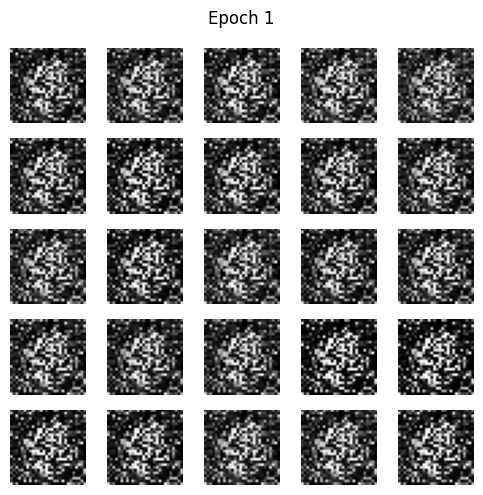

Epoch 2, Gen Loss: 3.6353, Disc Loss: 0.261526882648468


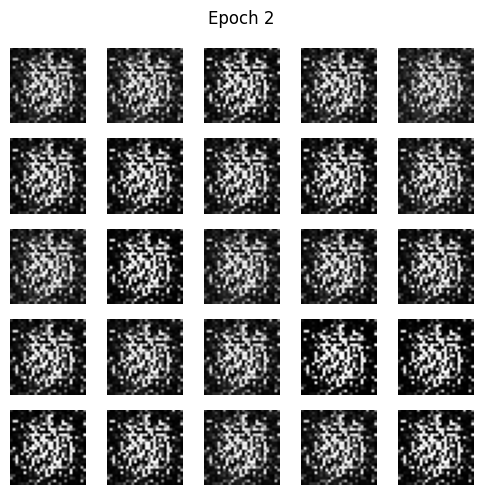

Epoch 3, Gen Loss: 3.0854, Disc Loss: 0.45836198329925537


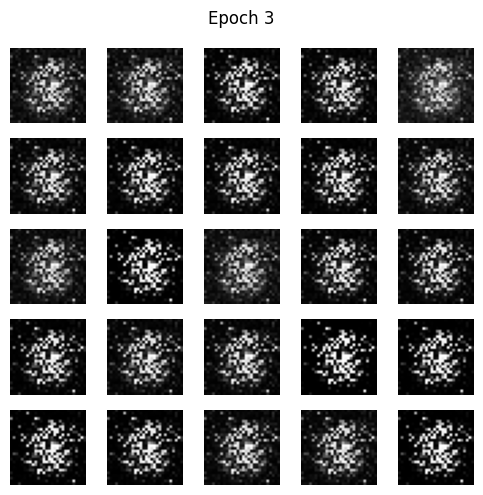

Epoch 4, Gen Loss: 2.2997, Disc Loss: 0.49793845415115356


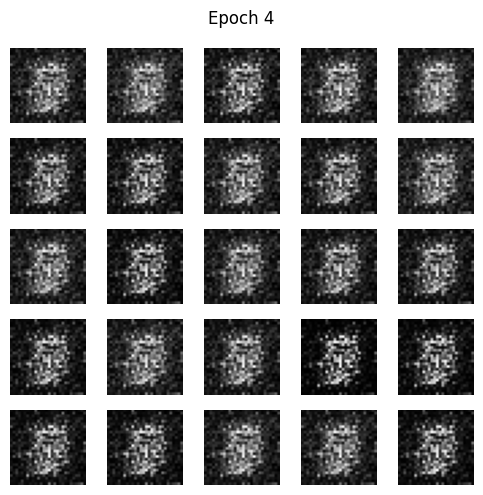

Epoch 5, Gen Loss: 2.4806, Disc Loss: 0.7486683130264282


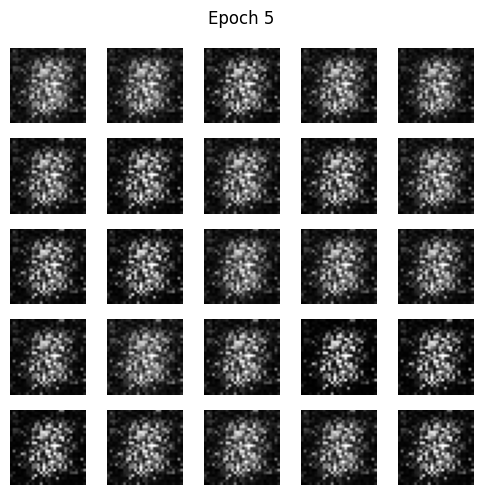

Epoch 6, Gen Loss: 1.6675, Disc Loss: 1.1759225130081177


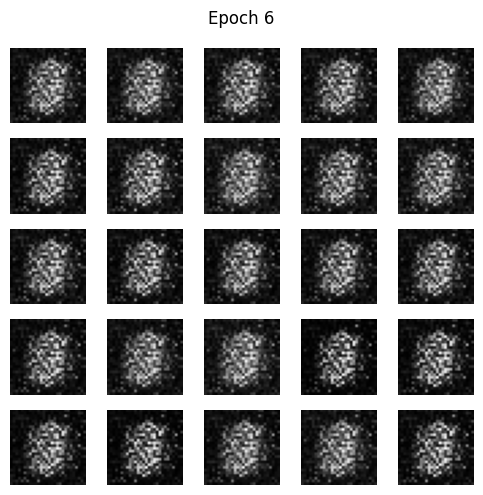

Epoch 7, Gen Loss: 1.7362, Disc Loss: 0.7245795726776123


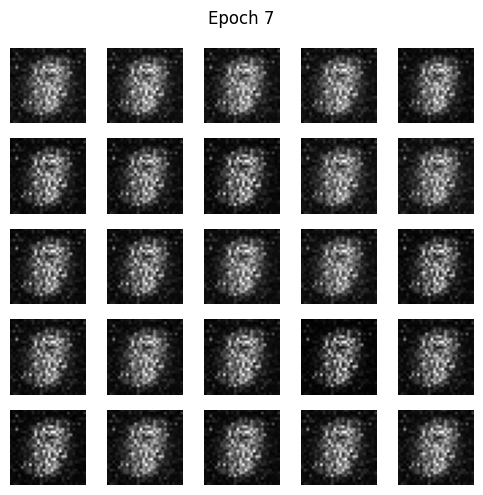

Epoch 8, Gen Loss: 3.2795, Disc Loss: 0.6952638626098633


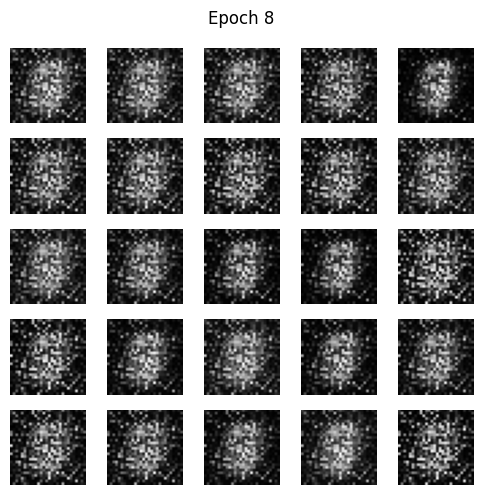

KeyboardInterrupt: 

In [28]:
train(dataset, epochs=50)

In [29]:
def evaluate_discriminator():
  noise = tf.random.normal([BATCH_SIZE, 100])
  generated_images = generator(noise, training=False)
  real_images = next(iter(dataset))
  real_preds = discriminator(real_images, training=False)
  fake_preds = discriminator(generated_images, training=False)

  real_acc = tf.reduce_mean(tf.cast(real_preds > 0.5, tf.float32))
  fake_acc = tf.reduce_mean(tf.cast(fake_preds < 0.5, tf.float32))

  print(f"Discriminator accuracy on real images: {real_acc.numpy()*100:.2f}%")
  print(f"Discriminator accuracy on fake images: {fake_acc.numpy()*100:.2f}%")

#

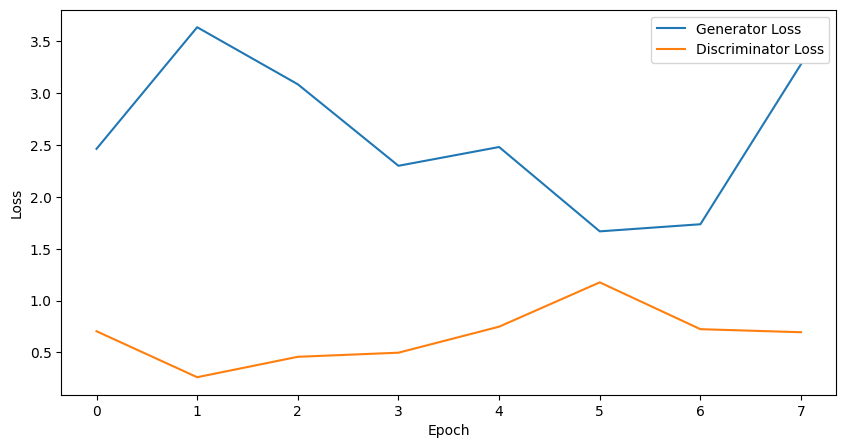

In [30]:
#visualizeing
plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid
plt.show()

In [31]:
#DISPLAY FINAL GENERATED IMAGES

def display_generated_images():
  noise = tf.random.normal([25, 100])
  generated_images = generator(noise, training=False)


  fig = plt.figure(figsize=(5, 5))
  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.suptitle("Generated Images")
  plt.tight_layout()
  plt.show()

display_generated_images

<function __main__.display_generated_images()>